In [ ]:
Regularized Regression and Variance Control

This project documents the systematic improvement of a regression model. The workflow transitions from 
a baseline linear model to a regularized 
Polynomial Ridge Regression model, utilizing target transformations and the One-Standard-Error (1-SE) rule
to ensure maximum generalization.

Project Overview: The goal was to predict a target variable while strictly managing the bia-variance tradeoff
inherent in high-dimensional feature spaces. The final implementation utilizes Lasso (L1) Regularization combined
with One-Standard-Error (1-SE) rule for alpha selection.
    
Project Evolution & Methodology
    1. Baseline Diagnostics and Transformation
    a. Initial Performance: The starting model achieved a CV R2 of 0.47.
    b. Error Analysis: Residual Plot shows non constant variance - heteroscedasticity, a violation of linear regression
    assumptions.
        
   c. Addressing Model Assumptions: To stabilize variance, a Yeo-Johnson transformation was applied to the target variable 
    y. The post-transformation CV R2 was 0.45, providing a more statistically sound 
foundation for further complexity.

   d. Feature Engineering: Expanded initial 15 features to 139 using Polynomial features, allowing the model to 
capture complex, non-linear signals.
    Initial Impact: This surge initially resulted in poorer metrics (Test R2 = -0.82) compared to the baseline. The is probably a feature of 
severe overfitting (Train R2 = 0.68) and high multicollinearity as confirmed during EDA.

   2. Regularization Strategy: To prevent overfitting, Lasso, Ridge, and Elastic Net were compared.
a. The 1-SE Rule: Instead of selecting the alpha that produced the absolute highest R2, the model selected
a simplier model (larger alpha) whose performance is within one standard error of the best result, allowing for
better generalization. 
 b. Winning Model: Lasso (L1) achieved a CV R2 of 0.50 and was selected as the final estimator, effectively zeroing out 91 redundant features and retaining
only 48 most impactful predictors.


 3. Model Validation and Performance Stability: 
a. Bootstrap Analysis: A bootstrap simulation was performed to establish a 95% confidence interval for $R^2$ 
(0.36 and 0.56).
b. Consistensy: The Out of Bag (OOB) score of 0.52 closely align with the cross validation score of 0.50,
confirming generalization.

c. Lasso vs Baseline Model Performance of Test Data: The lasso model resulted in a $R2$ of 0.55 on the test (held-out) data
while the baseline model was only able to achieve a $R2$ of 0.39 even though it has a CV $R2$ of 0.47. The regularized model
closed the generalization gap performing better in the test data than in the cross-validation and providing an
absolute increase of 0.16 $R2$ on test data.


    3. Key Takeaways
a. Feature Selection: Only 48 out of 139 features were necessary for peak performance.
b. Non-linearity: The top influential features were a mix of main effects and interaction terms, confirming
that a standard linear approach was insufficient for this dataset.
c. Reliability: Using the 1-SE sacrificed a small amount of training accuracy to achieve a stable test result.


d. Next Steps: Exploring non-linear estimators like trees based methods and ensembles given that poly 
terms were necessary to improve R2.

In [1251]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats

from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, StandardScaler
from sklearn.model_selection import (GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold,
                                    cross_val_predict, cross_validate, LearningCurveDisplay, learning_curve)
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import clone

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import BaggingRegressor

from sklearn.pipeline import Pipeline

In [1252]:
RANDOM_STATE = 785
warnings.filterwarnings('ignore')

In [1254]:
dta = pd.read_csv('./processed_data/processed_grains_data.csv')

In [1255]:
dta.head()

,Unnamed: 0,file_name,area,Length,Width,perimeter,Mean_Red,Mean_Green,Mean_Blue,Mean_Hue,Aspect_Ratio,Roundness,Red_Green_Ratio,Green_Blue_Ratio,Red_Minus_Blue,Mean_Saturation,Mean_Lightness,type,score
0,0,F5Con_0pct,12512.992481,172.390563,92.595783,449.906274,210.534748,142.107249,72.636900,30.223461,1.867552,5.288429,1.484346,1.970300,137.897847,0.655405,0.825626,F5,0
1,1,F5Con_10pct,11874.452555,170.894055,88.593213,441.983805,218.657378,154.605206,84.739661,31.545044,1.949513,5.096029,1.428969,1.895520,133.917716,0.615825,0.857480,F5,10
2,2,F5Con_15pct,11830.110345,170.422248,88.656826,441.984596,219.440003,155.617710,85.983421,31.569533,1.941898,5.111073,1.426868,1.892416,133.456582,0.612160,0.860549,F5,15
3,3,F5Con_1pct,12362.430894,172.121654,91.741002,448.775056,212.999753,144.547159,74.286850,30.417118,1.912233,5.243356,1.477921,1.968887,138.712903,0.651804,0.835293,F5,1
4,4,F5Con_20pct,11774.364780,169.909934,88.199890,440.073484,217.016723,153.763019,84.529784,31.588248,1.943333,5.106454,1.426017,1.895793,132.486939,0.613109,0.851046,F5,20


In [1256]:
dta.columns, dta.shape

(Index(['Unnamed: 0', 'file_name', 'area', 'Length', 'Width', 'perimeter',
        'Mean_Red', 'Mean_Green', 'Mean_Blue', 'Mean_Hue', 'Aspect_Ratio',
        'Roundness', 'Red_Green_Ratio', 'Green_Blue_Ratio', 'Red_Minus_Blue',
        'Mean_Saturation', 'Mean_Lightness', 'type', 'score'],
       dtype='object'),
 (957, 19))

In [1257]:
y = dta['score']
X = dta.drop(columns = ['Unnamed: 0', 'type', 'score'])

In [1258]:
Xtrain_df, Xtest_df, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)
Xtrain_df.shape, Xtest_df.shape

((765, 16), (192, 16))

In [1259]:
Xtrain_df.columns

Index(['file_name', 'area', 'Length', 'Width', 'perimeter', 'Mean_Red',
       'Mean_Green', 'Mean_Blue', 'Mean_Hue', 'Aspect_Ratio', 'Roundness',
       'Red_Green_Ratio', 'Green_Blue_Ratio', 'Red_Minus_Blue',
       'Mean_Saturation', 'Mean_Lightness'],
      dtype='object')

In [1260]:
ftrain = Xtrain_df['file_name']
ftest = Xtest_df['file_name']
Xtrain = Xtrain_df.drop(columns = ['file_name'])
Xtest = Xtest_df.drop(columns = ['file_name'])

In [1261]:
# Xtest.head()

In [1262]:
np.isinf(Xtrain).any()

area                False
Length              False
Width               False
perimeter           False
Mean_Red            False
Mean_Green          False
Mean_Blue           False
Mean_Hue            False
Aspect_Ratio        False
Roundness           False
Red_Green_Ratio     False
Green_Blue_Ratio    False
Red_Minus_Blue      False
Mean_Saturation     False
Mean_Lightness      False
dtype: bool

In [1263]:
# 1. Run CV with a baseline regression model

In [1264]:
def my_cross_validate_update(model, X, y, stratify = False, weights = None, return_estimator = False):
    
    scoring = {
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error',
    'r2': 'r2'
    }

    if stratify:
        y_binned = pd.qcut(y, q=5, labels = False, duplicates='drop')
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        cv_splits = list(skf.split(X, y_binned))
        cv_best = cross_validate(model, X, y, cv=cv_splits, scoring = scoring, params=weights, 
                                 return_estimator=return_estimator, return_train_score=True)
    else:
        cv_best = cross_validate(model, X, y, cv=5, scoring = scoring, params=weights, 
                                 return_estimator=return_estimator, return_train_score=True)

    estimator = None if return_estimator == False else cv_best['estimator']
    result = {
        'test_rmse' : round(float(np.sqrt(np.nanmean(-cv_best['test_mse']))), 2),
        'test_mae' : round(float(np.nanmean(-cv_best['test_mae'])),2),
        'test_r2' : round(float(np.nanmean(cv_best['test_r2'])),2),
        'test_r2_std': round(float(np.nanstd(cv_best['test_r2'])), 2),
        'estimator': estimator
    }

    other_res = {
        'train_rmse': round(float(np.sqrt(np.nanmean(-cv_best['train_mse']))), 2),
        'train_rmse_std' : round(float(np.sqrt(np.nanstd(-cv_best['train_mse']))), 2),
        
        'train_mae': round(float(np.nanmean(-cv_best['train_mae'])),2),
        'train_mae_std': round(float(np.nanstd(-cv_best['train_mae'])),2),
        
        'train_r2' : round(float(np.nanmean(cv_best['train_r2'])),2),
        'train_r2_std': round(float(np.nanstd(cv_best['train_r2'])), 2),

        'test_rmse_std' : round(float(np.sqrt(np.nanstd(-cv_best['test_mse']))), 2),
        'test_mae_std' : round(float(np.nanstd(-cv_best['test_mae'])),2),

        
    }

    gap = {
        'rmse_gap': np.round(abs(other_res["train_rmse"] - result["test_rmse"]), 3),
        'mae_gap': np.round(abs(other_res["train_mae"] - result["test_mae"]), 3),
        'r2_gap': np.round((other_res["train_r2"] - result["test_r2"]), 3)
    }

    r2_ratio = np.round(gap['r2_gap']/other_res['train_r2']*100, 2)
    mae_ratio = np.round(gap['mae_gap']/other_res['train_mae']*100, 2)
    rmse_ratio = np.round(gap['rmse_gap']/other_res['train_rmse']*100, 2)

    print('Cross Validation Results')
    print('='*60)
    print(f'\nTrain Metrics')
    
    print(f'  Train RMSE: {other_res["train_rmse"]} +/- {other_res["train_rmse_std"]}')
    print(f'  Train MAE: {other_res["train_mae"]}  +/- {other_res["train_mae_std"]}')
    print(f'  Train R2: {other_res["train_r2"]} +/- {other_res["train_r2_std"]}')

    print(f'\nTest Metrics')
    print(f'  Test RMSE: {result["test_rmse"]} +/- {other_res["test_rmse_std"]}')
    print(f'  Test MAE: {result["test_mae"]}  +/- {other_res["test_mae_std"]}')
    print(f'  Test R2: {result["test_r2"]} +/- {result["test_r2_std"]}')

    print(f'\nOverfitting Gap')

    print(f"  RMSE: {gap['rmse_gap']} ({rmse_ratio}%)")
    print(f"  MAE: {gap['mae_gap']} ({mae_ratio}%)")
    print(f"  R2: {gap['r2_gap']} ({r2_ratio}%)")

    print('\n')

    return result

In [1265]:
# 1. Baseline Diagnostics and Transformation

In [1266]:
baseline_mod = LinearRegression()

my_cross_validate_update(baseline_mod, Xtrain, ytrain)


Cross Validation Results

Train Metrics
  Train RMSE: 13.51 +/- 2.76
  Train MAE: 9.93  +/- 0.21
  Train R2: 0.51 +/- 0.02

Test Metrics
  Test RMSE: 13.96 +/- 5.49
  Test MAE: 10.27  +/- 0.61
  Test R2: 0.47 +/- 0.06

Overfitting Gap
  RMSE: 0.45 (3.33%)
  MAE: 0.34 (3.42%)
  R2: 0.04 (7.84%)




{'test_rmse': 13.96,
 'test_mae': 10.27,
 'test_r2': 0.47,
 'test_r2_std': 0.06,
 'estimator': None}

In [1267]:
my_cross_validate_update(baseline_mod, Xtrain, ytrain, stratify = True)

Cross Validation Results

Train Metrics
  Train RMSE: 13.48 +/- 2.99
  Train MAE: 9.96  +/- 0.14
  Train R2: 0.51 +/- 0.02

Test Metrics
  Test RMSE: 14.26 +/- 6.82
  Test MAE: 10.26  +/- 0.47
  Test R2: 0.46 +/- 0.08

Overfitting Gap
  RMSE: 0.78 (5.79%)
  MAE: 0.3 (3.01%)
  R2: 0.05 (9.8%)




{'test_rmse': 14.26,
 'test_mae': 10.26,
 'test_r2': 0.46,
 'test_r2_std': 0.08,
 'estimator': None}

In [417]:
# 1a. Generate Residuals from Xtrain

In [1268]:
y_train_pred = cross_val_predict(baseline_mod, Xtrain, ytrain, cv = 5)
residuals = ytrain - y_train_pred
result_df = pd.DataFrame({
    'ytrain_pred': y_train_pred, 
    'ytrain' : ytrain,
    'residuals': residuals
})

In [1269]:
WIDTH = 800
HEIGHT = 600

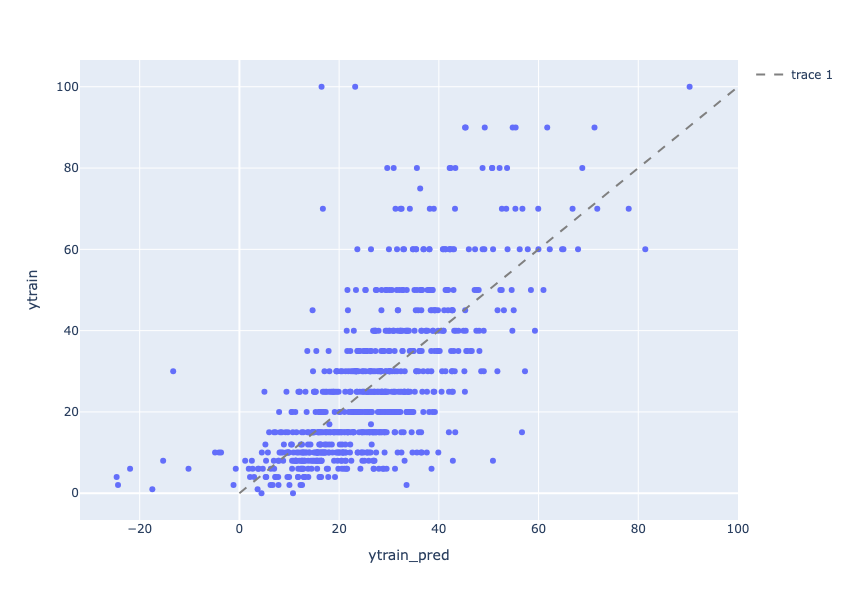

In [1270]:
fig = px.scatter(result_df, x = 'ytrain_pred', y = 'ytrain', width=WIDTH, height=HEIGHT, )
fig.add_scatter(x = [0,100], y = [0, 100], mode = 'lines', line = dict(color = 'grey', dash = 'dash'))

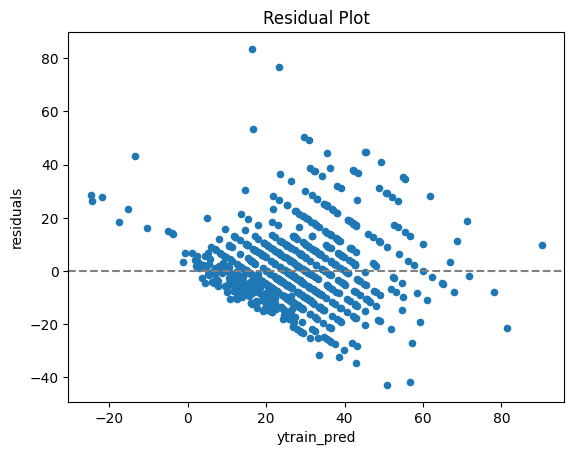

In [1271]:
ax = result_df.plot.scatter(x = 'ytrain_pred', y = 'residuals', title = 'Residual Plot')
ax.axhline(y = 0, color = 'grey', linestyle = '--')

In [1272]:
# 1b. Residual Plot shows non constant variance - heteroscedasticity, a violation of linear regression
# y target values are right skewed, necessitating Power Transform.

In [1273]:
ytrain_df = pd.DataFrame({"y": ytrain})

<Axes: ylabel='Count'>

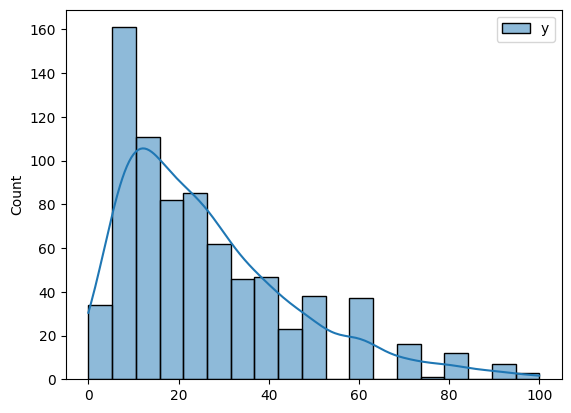

In [1274]:
sns.histplot(ytrain_df, kde = True)

In [1275]:
pt = PowerTransformer() # yeo-johnson
ytrain_yj = pt.fit_transform(ytrain_df)

<Axes: ylabel='Count'>

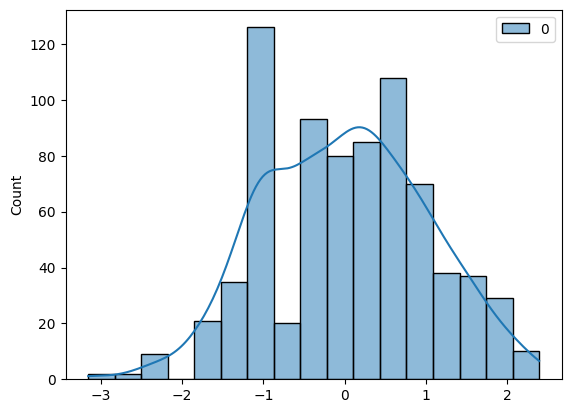

In [1276]:
sns.histplot(ytrain_yj, kde = True)

In [1277]:
# Add Poly features

In [1278]:
scoring = {
    'r2' : 'r2',
    'mae' : 'neg_mean_absolute_error',
    'mse' : 'neg_mean_squared_error'
}

In [1279]:
pipeline = Pipeline([
    ('power_x', PowerTransformer()),
    ('regressor', LinearRegression())
])

mod_inv = TransformedTargetRegressor(
    regressor = pipeline,
    transformer = PowerTransformer()
)


results = my_cross_validate_update(mod_inv, Xtrain, ytrain, stratify = True)


Cross Validation Results

Train Metrics
  Train RMSE: 13.76 +/- 2.79
  Train MAE: 9.61  +/- 0.13
  Train R2: 0.49 +/- 0.02

Test Metrics
  Test RMSE: 14.32 +/- 6.27
  Test MAE: 9.86  +/- 0.5
  Test R2: 0.45 +/- 0.08

Overfitting Gap
  RMSE: 0.56 (4.07%)
  MAE: 0.25 (2.6%)
  R2: 0.04 (8.16%)




In [1280]:
# 2. Power Transformation did not meet up with the baseline with R2 and RMSE. Small boost in MAE. 

In [1281]:
# 2a.Poly features introduce to increase model complexity 
DEGREE = 2

In [1282]:
pipeline = Pipeline([
    ('power_x', PowerTransformer()),
    ('poly', PolynomialFeatures(degree=DEGREE)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

model_poly = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=PowerTransformer()
)

results = my_cross_validate_update(model_poly, Xtrain, ytrain, stratify = True)


Cross Validation Results

Train Metrics
  Train RMSE: 10.86 +/- 1.74
  Train MAE: 7.63  +/- 0.12
  Train R2: 0.68 +/- 0.02

Test Metrics
  Test RMSE: 27.38 +/- 29.49
  Test MAE: 11.81  +/- 2.09
  Test R2: -0.82 +/- 1.82

Overfitting Gap
  RMSE: 16.52 (152.12%)
  MAE: 4.18 (54.78%)
  R2: 1.5 (220.59%)




In [1284]:
# 2b.Adding Poly Features led to poorer metrics compared to the baseline. Overfitted as shown with the GAP

In [1283]:
# 3. Regularization.
# Three Regularization Methods are employed. Lasso, Ridge, and Elastic Net.
# NOTE on Regularization. Grid search for alpha did not select the alpha with the best mean,
# instead, it selected an alpha value with mean value within one standard error from best_mean.
# Generally, this method will select an alpha higher than that with the best mean, allowing better 
# generalization. 

In [1289]:
# Utility function to process grid model, return input for plots as well as model metrics

def train_test_plot(cv_results, alphas, name, folds=5):

    # names should be either Lasso, Ridge, or ElasticNet
    
    # cv_results = res.cv_results_
    test_means = cv_results['mean_test_r2']
    train_means = cv_results['mean_train_r2']

    # do this check - mostly for Lasso
    mask = ~np.isnan(test_means)
    # mask_train = ~np.isnan(train_scores)
    
    a_plot = alphas[mask]
    s_test = test_means[mask]
    s_train = train_means[mask]

    test_stds = cv_results['std_test_r2']
    se = test_stds/np.sqrt(folds)
    
    # Best Alpha - greedy approach
    best_idx = np.argmax(s_test)
    best_alpha = alphas[best_idx]
    best_mean = s_test[best_idx]
    best_se = se[best_idx]

    # best_std = test_stds[best_idx]

    # one se from test mean
    threshold = best_mean - best_se
    
    # simplest model - larger alpha lead to better generalization  
    possible_idx = np.where(s_test > threshold)[0]
    if possible_idx.size > 0:
        simplex_idx = possible_idx[np.argmax(alphas[possible_idx])]
    else: # in case there is a big dip after the best mean ie no mean with 1-SE, possible_idx will be empty
        simplex_idx = best_idx
    safer_a = alphas[simplex_idx]

    safer_alpha_test_mean = s_test[simplex_idx]
    safer_alpha_train_mean = s_train[simplex_idx]

    alpha_ratio = float(safer_a/best_alpha)
    ar_label = f"Alpha ratio: {alpha_ratio:.2f}x"



    # return plotting

    plt.semilogx(a_plot, s_test, label = 'Val R2')
    plt.semilogx(a_plot, s_train, label = 'Train R2', linestyle = '--')

    plt.scatter(a_plot[best_idx], best_mean, color = 'red', zorder = 5, label = f'Best R2: {best_mean:.3f}')
    plt.scatter(a_plot[best_idx], s_train[best_idx], color = 'red', zorder = 5)

    plt.axhline(threshold, color = 'red', linestyle = '-', alpha = 0.3, label = f'1-SE Threshold ({threshold:.3f})')
    plt.scatter(safer_a, safer_alpha_test_mean, color = 'green', marker='*', label = 'Selected (Safe) Alpha', s=100, edgecolor='black')

    plt.scatter(safer_a, safer_alpha_train_mean, color = 'green', marker='*', label = f'{ar_label}', s=100, edgecolor='black')

    # best_idx = np.argmax(s_test_r)
    # plt.scatter(a_plot_r[best_idx], color = 'purple', linestyle = ':', alpha = 0.8, label=f'Best Alpha: {a_plot_r[best_idx]:.2e}')
    plt.ylabel('R2 Score')
    plt.xlabel('Regularization Strength (Alpha)')
    plt.title(f'{name} Optimization - Impact on Model Fit')
    plt.legend()

    if 'ElasticNet' in name:
        l1_ratio = cv_results['param_regressor__en__l1_ratio'].data.astype(float)
        safe_l1_ratio = l1_ratio[simplex_idx]
        return float(safer_a), float(safe_l1_ratio)
    
    else:

        return float(safer_a)

In [ ]:
# 2. Regularization Strategy: 

In [434]:
# Lasso

In [1287]:
scoring_metrics = {
    'r2' : 'r2',
    'mae' : 'neg_mean_absolute_error',
    'mse' : 'neg_mean_squared_error'
}

In [1288]:
pipeline = Pipeline([
    ('power_x', PowerTransformer()),
    ('poly', PolynomialFeatures(degree = DEGREE)),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=1000))
])

alpha_range = np.logspace(-4, 2, 50)

params = {
    'regressor__lasso__alpha' : alpha_range
}

pipe_mod = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=PowerTransformer()
)

grid_search = GridSearchCV(pipe_mod, params, cv = 5, scoring = scoring_metrics, refit = 'r2', return_train_score=True)

cv_res = my_cross_validate_update(grid_search, Xtrain, ytrain, stratify=True, return_estimator=True)

Cross Validation Results

Train Metrics
  Train RMSE: 12.74 +/- 3.77
  Train MAE: 9.0  +/- 0.45
  Train R2: 0.57 +/- 0.04

Test Metrics
  Test RMSE: 13.61 +/- 5.95
  Test MAE: 9.61  +/- 0.68
  Test R2: 0.5 +/- 0.12

Overfitting Gap
  RMSE: 0.87 (6.83%)
  MAE: 0.61 (6.78%)
  R2: 0.07 (12.28%)




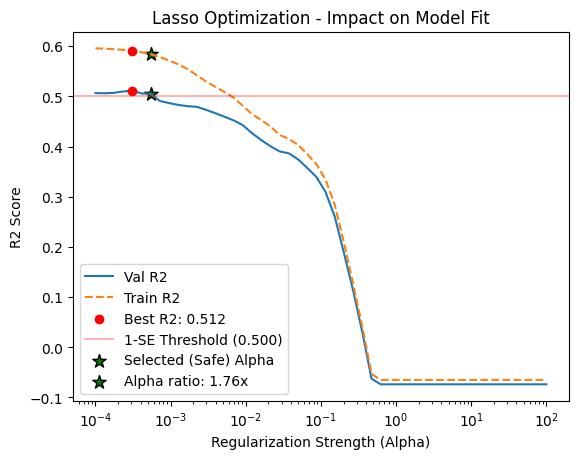

In [1290]:
grid_search.fit(Xtrain, ytrain)

res = grid_search.cv_results_
alphas = res['param_regressor__lasso__alpha'].data.astype(float)

lasso_alpha = train_test_plot(res, alphas, 'Lasso')

In [ ]:
# Ridge

In [1291]:
pipeline = Pipeline([
    ('power_x', PowerTransformer()),
    ('poly', PolynomialFeatures(degree = DEGREE)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=RANDOM_STATE)),
    # ('regressor', LinearRegression())
])

alpha_range = np.logspace(-4, 2, 50)
params = {
    'regressor__ridge__alpha' : alpha_range
}

pipe_mod = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=PowerTransformer()
)

grid_ridge = GridSearchCV(pipe_mod, params, cv = 5, scoring = scoring_metrics, refit = 'r2', return_train_score=True)

cv_ridge = my_cross_validate_update(grid_ridge, Xtrain, ytrain, stratify=True, return_estimator=True)


Cross Validation Results

Train Metrics
  Train RMSE: 12.52 +/- 3.45
  Train MAE: 8.84  +/- 0.39
  Train R2: 0.58 +/- 0.03

Test Metrics
  Test RMSE: 13.68 +/- 5.78
  Test MAE: 9.59  +/- 0.54
  Test R2: 0.49 +/- 0.1

Overfitting Gap
  RMSE: 1.16 (9.27%)
  MAE: 0.75 (8.48%)
  R2: 0.09 (15.52%)




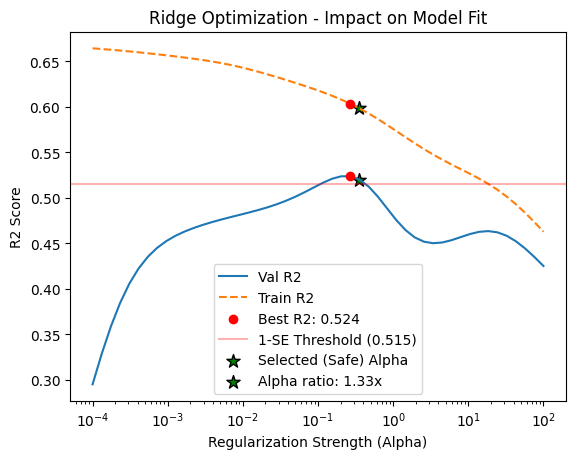

In [1292]:
grid_ridge.fit(Xtrain, ytrain)

cv_ridge_res = grid_ridge.cv_results_
alphas = cv_ridge_res['param_regressor__ridge__alpha'].data.astype(float)

ridge_alpha = train_test_plot(cv_ridge_res, alphas, 'Ridge')


In [1293]:
# see if doing a kselect before poly helps

In [1294]:
K = [5, 8, 10, 11, 12, 13, 14, 15]
k_score = []
for k in K:
    pipeline = Pipeline([
        ('power_x', PowerTransformer()),
        ('feature_select', SelectKBest(f_regression, k=k)),
        ('poly', PolynomialFeatures(degree = DEGREE)),
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=RANDOM_STATE)),
        # ('regressor', LinearRegression())
    ])
    
    alpha_range = np.logspace(-4, 2, 50)
    
    params = {
        'regressor__ridge__alpha' : alpha_range
    }
    
    pipe_mod = TransformedTargetRegressor(
        regressor=pipeline,
        transformer=PowerTransformer()
    )
    
    scores = cross_val_score(pipe_mod, Xtrain, ytrain, cv=5, scoring='r2')
    k_score.append(scores.mean())
    print(f"k={k}: R2 = {scores.mean():.3f} ± {scores.std():.3f}")

k_best_idx = np.where(k_score == np.max(k_score))[0][0]
k_best = K[k_best_idx]
k_best

k=5: R2 = 0.399 ± 0.026
k=8: R2 = 0.223 ± 0.450
k=10: R2 = 0.416 ± 0.151
k=11: R2 = 0.462 ± 0.096
k=12: R2 = 0.482 ± 0.062
k=13: R2 = 0.490 ± 0.047
k=14: R2 = 0.482 ± 0.071
k=15: R2 = 0.480 ± 0.074


13

In [1295]:
pipeline = Pipeline([
    ('power_x', PowerTransformer()),
    ('feature_select', SelectKBest(f_regression, k=k_best)),
    ('poly', PolynomialFeatures(degree = DEGREE)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=RANDOM_STATE)),
    # ('regressor', LinearRegression())
])

alpha_range = np.logspace(-4, 2, 50)

params = {
    'regressor__ridge__alpha' : alpha_range
}

pipe_mod = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=PowerTransformer()
)

grid_ridge_kbest = GridSearchCV(pipe_mod, params, cv = 5, scoring = scoring_metrics, 
                            refit = 'r2', return_train_score=True)

cv_ridge_kbest = my_cross_validate_update(grid_ridge_kbest, Xtrain, ytrain, stratify = True, return_estimator=True)


Cross Validation Results

Train Metrics
  Train RMSE: 12.24 +/- 3.5
  Train MAE: 8.62  +/- 0.33
  Train R2: 0.6 +/- 0.04

Test Metrics
  Test RMSE: 13.77 +/- 6.28
  Test MAE: 9.66  +/- 0.62
  Test R2: 0.48 +/- 0.12

Overfitting Gap
  RMSE: 1.53 (12.5%)
  MAE: 1.04 (12.06%)
  R2: 0.12 (20.0%)




0.35564803062231287

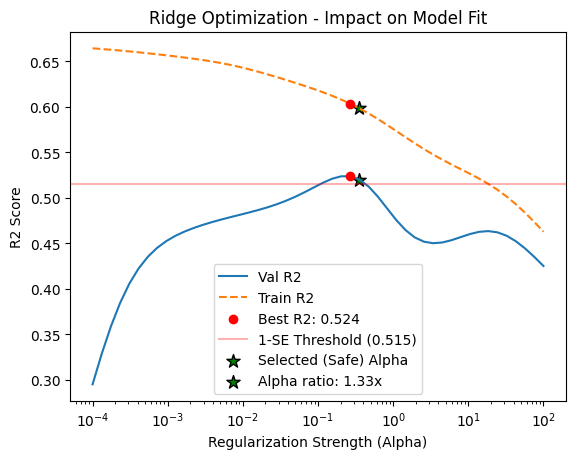

In [1296]:
grid_ridge_kbest.fit(Xtrain, ytrain)

cv_ridge_res_kbest = grid_ridge.cv_results_
alphas = cv_ridge_res_kbest['param_regressor__ridge__alpha'].data.astype(float)

train_test_plot(cv_ridge_res_kbest, alphas, 'Ridge')

In [ ]:
# kbest did not help

In [439]:
# ElasticNet

In [1297]:
pipeline = Pipeline([
    ('power_x', PowerTransformer()),
    ('poly', PolynomialFeatures(degree = DEGREE)),
    ('scaler', StandardScaler()),
    ('en', ElasticNet(max_iter=1000)),
    # ('regressor', LinearRegression())
])

params = {
    'regressor__en__alpha' : np.logspace(-4, 2, 50),
    'regressor__en__l1_ratio' : np.linspace(0.1, 0.9, 9)
}

pipe_mod = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=PowerTransformer()
)

grid_en = GridSearchCV(pipe_mod, params, cv = 5, scoring = scoring_metrics, refit = 'r2', return_train_score=True)

cv_en = my_cross_validate_update(grid_en, Xtrain, ytrain, stratify=True, return_estimator=True)


Cross Validation Results

Train Metrics
  Train RMSE: 12.77 +/- 3.67
  Train MAE: 9.03  +/- 0.42
  Train R2: 0.56 +/- 0.03

Test Metrics
  Test RMSE: 13.64 +/- 5.87
  Test MAE: 9.64  +/- 0.65
  Test R2: 0.49 +/- 0.11

Overfitting Gap
  RMSE: 0.87 (6.81%)
  MAE: 0.61 (6.76%)
  R2: 0.07 (12.5%)




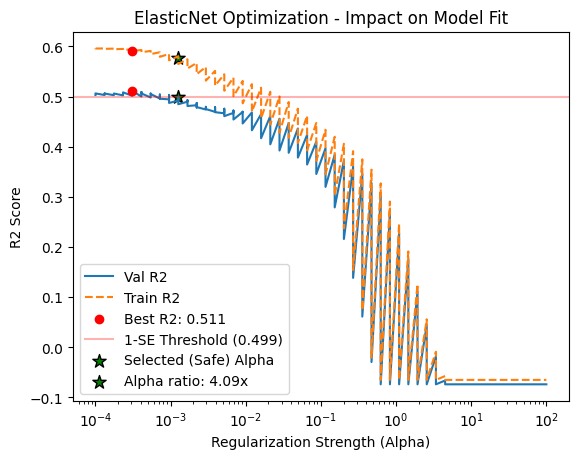

In [1298]:
grid_en.fit(Xtrain, ytrain)

res_en = grid_en.cv_results_
alphas = res_en['param_regressor__en__alpha'].data.astype(float)

en_alpha, en_l1_ratio = train_test_plot(res_en, alphas, 'ElasticNet')



In [ ]:
# 3. Model Validation and Performance Stability: 

In [ ]:
# Visualize all the three regularization models

In [1299]:
def regularization_coefficient(grid_lasso, grid_ridge, grid_en, feature_names=None):

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    models = [
        ('ridge', grid_ridge, 'blue'),
        ('lasso', grid_lasso, 'red'),
        ('en', grid_en, 'green')
    ]
    
    for ax, (name, model, color) in zip(axes, models):
        coefs = model.regressor_.named_steps[name].coef_  
        
        abs_coefs = np.abs(coefs)
        sorted_idx = np.argsort(abs_coefs)[::-1]
        sorted_coefs = coefs[sorted_idx]

        x = np.arange(len(sorted_coefs))
        ax.bar(x, sorted_coefs, color=color, alpha=0.7, linewidth=0.5)
        ax.axhline(0, color='black', linestyle='-', linewidth=1)
        ax.set_xlabel('Feature Index (sorted by importance)', fontsize=11)
        ax.set_ylabel('Coefficient', fontsize=11)
        ax.set_title(f'{name}: Distribution of Features\n'
                    f'Non-zero: {np.sum(np.abs(sorted_coefs) > 1e-5)}/{len(sorted_coefs)}',
                    fontsize=13, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()



In [1304]:
final_lasso = clone(grid_search.best_estimator_)
final_lasso.set_params(regressor__lasso__alpha = lasso_alpha)
final_lasso.fit(Xtrain, ytrain)
pass


In [1301]:
final_ridge = clone(grid_ridge.best_estimator_)
final_ridge.set_params(regressor__ridge__alpha = ridge_alpha)
final_ridge.fit(Xtrain, ytrain)
pass

In [1302]:
final_en = clone(grid_en.best_estimator_)
final_en.set_params(regressor__en__alpha = en_alpha, regressor__en__l1_ratio = en_l1_ratio)
final_en.fit(Xtrain, ytrain)
pass

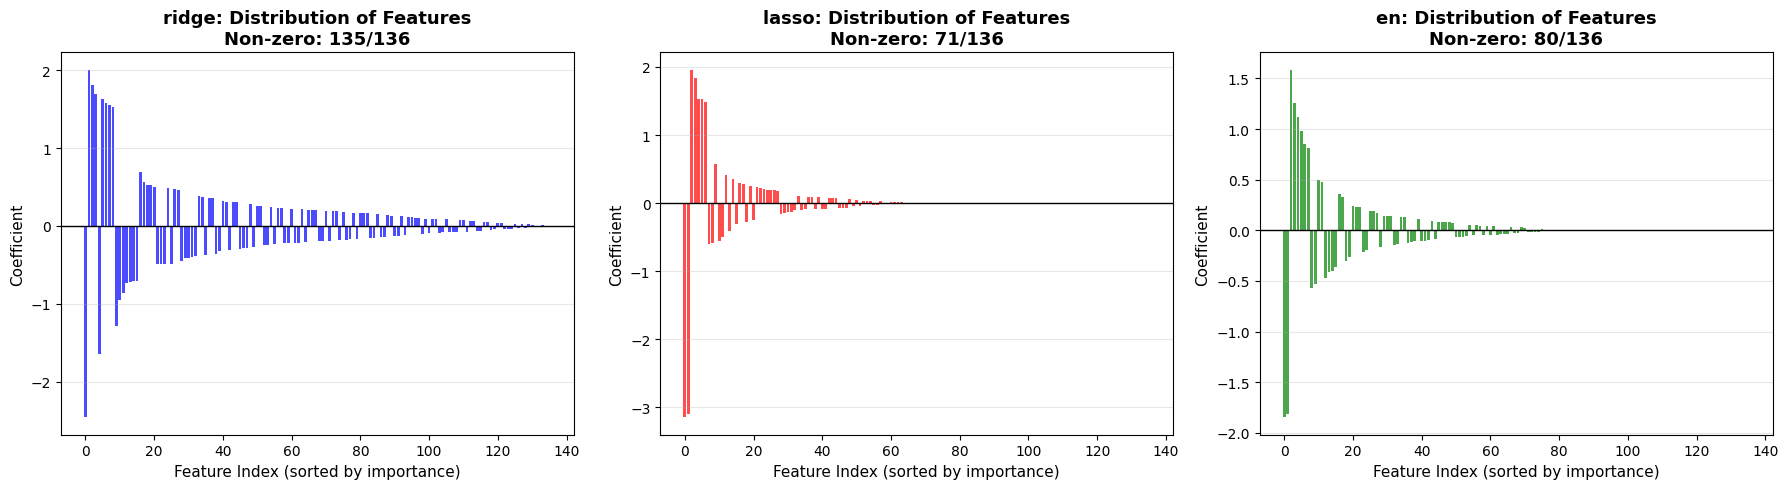

In [1305]:
regularization_coefficient(final_lasso, final_ridge, final_en)

In [1316]:
for_bt_lasso = clone(grid_search.best_estimator_)
for_bt_lasso.set_params(regressor__lasso__alpha = lasso_alpha)

bootstrap_model = BaggingRegressor(
    estimator=for_bt_lasso,
    n_estimators=2000,
    bootstrap=True,
    oob_score=True,
    random_state=RANDOM_STATE
)

bootstrap_model.fit(Xtrain, ytrain)

scores = []
for estimator in bootstrap_model.estimators_:
    scores.append(estimator.score(Xtrain, ytrain))

In [1317]:
mean_r2 = np.mean(scores)
ci_lower = np.percentile(scores, 2.5)
ci_upper = np.percentile(scores, 97.5)
# 

print('Boostrap Results on Out of Bag (OOB) (Lasso)')
print('='*45)

print(f'\nOOB Metrics')

print(f'  OOB R2: {mean_r2:.2f}')
print(f'  OOB R2 Confidence Intervals: ({ci_lower:.2f}, {ci_upper:.2f})')

Boostrap Results on Out of Bag (OOB) (Lasso)

OOB Metrics
  OOB R2: 0.52
  OOB R2 Confidence Intervals: (0.30, 0.57)


In [1318]:

# best_model = grid_ridge.best_estimator_

column_names = Xtrain.columns.tolist()

poly_estimator = final_lasso.regressor_['poly']
fe_names = poly_estimator.get_feature_names_out(input_features = column_names)

print(f'Total Poly Features: {len(fe_names)}')
coefs = final_lasso.regressor_['lasso'].coef_

imp_df = pd.DataFrame({
    'Feature': fe_names,
    'Coefficient': coefs
})


imp_df['Abs_Coefficient'] = imp_df['Coefficient'].abs()
imp_df = imp_df.sort_values(by='Abs_Coefficient', ascending=False)

imp_df.head(15)

Total Poly Features: 136


,Feature,Coefficient,Abs_Coefficient
13,Red_Minus_Blue,-3.148311,3.148311
1,area,-3.105429,3.105429
8,Mean_Hue,1.962071,1.962071
6,Mean_Green,1.832352,1.832352
3,Width,1.526056,1.526056
11,Red_Green_Ratio,1.521944,1.521944
4,perimeter,1.479611,1.479611
126,Green_Blue_Ratio^2,-0.601120,0.601120
15,Mean_Lightness,-0.579997,0.579997
123,Red_Green_Ratio Red_Minus_Blue,0.571725,0.571725


Text(0.5, 1.0, 'Top 15 Features - Ridge Model')

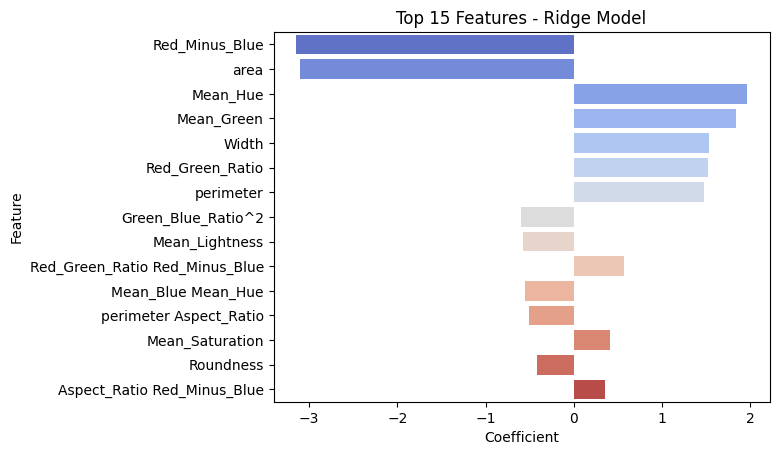

In [1319]:
sns.barplot(imp_df.head(15), x='Coefficient', y='Feature', palette='coolwarm')
plt.title('Top 15 Features - Ridge Model')

In [ ]:
# 3a.Final Model Training on Lasso L1 Regularization. This model produced the largest CV R2. This metric
# is five percentage points higher than the base model CV R2.

In [1320]:

pred = final_lasso.predict(Xtest)
r2 = r2_score(ytest, pred)
mae = mean_absolute_error(ytest, pred)
rmse = np.sqrt(mean_squared_error(ytest, pred))


print('Lasso Results on Test Data')
print('='*30)

print(f'\nTest Metrics')
print(f'  Test RMSE: {rmse:.2f}')
print(f'  Test MAE: {mae:.2f}')
print(f'  Test R2: {r2:.2f}')

Lasso Results on Test Data

Test Metrics
  Test RMSE: 12.56
  Test MAE: 9.27
  Test R2: 0.56


In [ ]:
# Baseline model

In [1321]:
baseline_mod.fit(Xtrain, ytrain)
baseline_pred = baseline_mod.predict(Xtest)
baseline_r2 = r2_score(ytest, baseline_pred)
baseline_mae = mean_absolute_error(ytest, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(ytest, baseline_pred))


print('Baseline Model Results on Test Data')
print('='*40)

print(f'\nTest Metrics')
print(f'  Test RMSE: {baseline_rmse:.2f}')
print(f'  Test MAE: {baseline_mae:.2f}')
print(f'  Test R2: {baseline_r2:.2f}')

Baseline Model Results on Test Data

Test Metrics
  Test RMSE: 14.73
  Test MAE: 10.62
  Test R2: 0.39


In [1322]:
rmse_gap = abs(rmse - baseline_rmse)
rmse_gap_pct = (rmse_gap/rmse)*100

mae_gap = abs(mae - baseline_mae)
mae_gap_pct = (mae_gap/mae)*100

r2_gap = r2 - baseline_r2
r2_gap_pct = (r2_gap/baseline_r2)*100


print('Lasso Metrics vs Baseline')
print('='*30)

print(f'\nTest Metrics')
print(f'  RMSE Gap: {rmse_gap:.2f} ({rmse_gap_pct:.2f}%)')
print(f'  MAE Gap: {mae_gap:.2f} ({mae_gap_pct:.2f}%)')
print(f'  R2 Gap: {r2_gap:.2f} ({r2_gap_pct:.2f}%)')

Lasso Metrics vs Baseline

Test Metrics
  RMSE Gap: 2.18 (17.33%)
  MAE Gap: 1.35 (14.57%)
  R2 Gap: 0.17 (42.42%)


In [172]:
results_df = pd.DataFrame({
    'pred' : pred,
    'ytest' : ytest,
    'fname' : ftest,
    'residual' : ytest - pred
})

fig = px.scatter(results_df, x = 'pred', y = 'ytest', hover_data = 'fname', width=WIDTH, height=HEIGHT, title='Ridge Prediction on Test, R2 = 0.55')
fig.add_scatter(x = [0,100], y = [0, 100], mode = 'lines', line = dict(color = 'grey', dash = 'dash'))

In [200]:


def compare_lasso_and_baseline(models_dict, Xtest, ytest):

    results = []
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    


    for i, (name, model) in enumerate(models_dict.items()):
        
        preds = model.predict(Xtest)
        residuals = ytest - preds
        
        
        mae = mean_absolute_error(ytest, preds)
        mse = mean_squared_error(ytest, preds)
        r2 = r2_score(ytest, preds)
        
        results.append({
            'Model': name,
            'Test R2': round(r2, 2),
            'Test MAE': round(-mae, 2),
            'Test MSE': round(np.sqrt(-mse), 2)
        })
        
        
        sns.scatterplot(x=preds, y=residuals, ax=axes[i], alpha=0.5)
        axes[i].axhline(0, color='red', linestyle='--')
        axes[i].set_title(f'Residuals: {name}\n(Test R2: {r2:.2f})')
        axes[i].set_xlabel('Predicted')
        if i == 0:
            axes[i].set_ylabel('Residuals (Actual - Predicted)')

    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(results).set_index('Model')



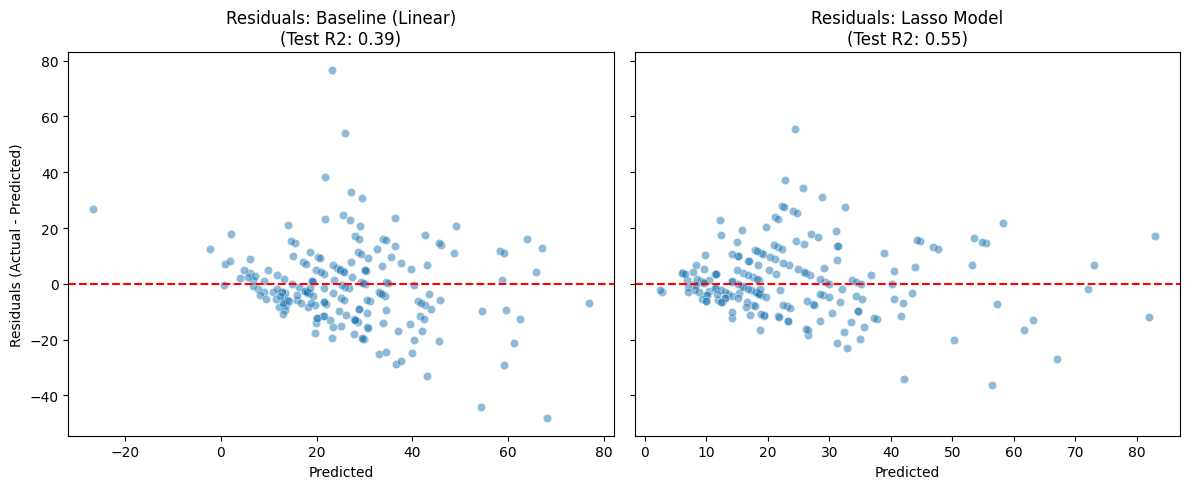

In [201]:
model_dict = {
    "Baseline (Linear)": baseline_mod,
    "Lasso Model": final_lasso 
}

comparison_df = compare_lasso_and_baseline(model_dict, Xtest, ytest)